In [316]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [317]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk # just for tokenization
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random
import gradio 
import string
import tensorflow as tf
import datetime

random.seed(42)

In [318]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()
# wv_from_bin = load_embedding_model()

KeyboardInterrupt: 

In [ ]:
benchmark_df = pd.read_csv("../../data/million_songs.csv")
benchmark_df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [ ]:
def tokenize(lyric: str) -> list[str]:
    # lowercase the text, remove stop words, punctuation and keep only the words
    lyric.replace("<br>", "\n")
    tokens = nltk.tokenize.word_tokenize(lyric.lower())
    stop_words = stopwords.words("english") + list(string.punctuation)
    lemmatizer = WordNetLemmatizer()
    alpha_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]

    return alpha_tokens

In [ ]:
def vectorise(lyrics: str) -> np.ndarray:
    tokens = tokenize(lyrics)
    lyric_vector = np.zeros(300)
    for token in tokens:
        try:
            lyric_vector += wv_from_bin.get_vector(token.lower())
        except:
            continue
    return lyric_vector / np.linalg.norm(lyric_vector)

In [ ]:
# go through each lyrics, tokenize it, vectorize each word, then combine all of them into single average vector and store it in the list

def get_embeddings(lyrics):
    lyrics_embeddings = []
    unsupported_tokens = set()
    label_embedding_map = {} # dict{str: np.array([])}
    for lyric in tqdm(lyrics):
        lyric_vector = np.zeros(300)
        for token in tokenize(lyric):
            try:
                lyric_vector += wv_from_bin.get_vector(token.lower())
            except KeyError as e:
                # if the word is not present in the glove then key error is raised, so handle the exception and move on
                unsupported_tokens.add(token)
                continue
        lyrics_embeddings.append(lyric_vector)


    lyrics_embeddings = np.stack(lyrics_embeddings)
    scaled_lyrics_embeddings = lyrics_embeddings / np.linalg.norm(lyrics_embeddings, axis=1, keepdims=True)
    return scaled_lyrics_embeddings

In [ ]:
train_embeddings = get_embeddings(benchmark_df["text"])

100%|██████████| 57650/57650 [02:34<00:00, 372.40it/s]


In [ ]:
def distance(metric: str, embedding_matrix: np.ndarray, test_vector: np.ndarray) -> np.ndarray:
    if metric == "cosine":
            
        dot_product = np.dot(embedding_matrix, test_vector)

        # Compute magnitudes
        embedding_magnitudes = np.linalg.norm(embedding_matrix, axis=1)
        test_vector_magnitude = np.linalg.norm(test_vector)

        # Compute cosine similarity
        cosine_similarity = dot_product / (embedding_magnitudes * test_vector_magnitude)
        return cosine_similarity
    elif metric == "euclidean":
        distances = np.linalg.norm(scaled_lyrics_embeddings - test_vector, axis=1)
        return distances
    else:
        raise Exception(f"Invalid parameter value {metric}")

In [ ]:
def cosine_distance(X, centroids):
    # Compute cosine similarity between each data point and each centroid
    dot_product = np.dot(X, centroids.T)
    norms_X = np.linalg.norm(X, axis=1)[:, np.newaxis]
    norms_centroids = np.linalg.norm(centroids, axis=1)
    cosine_similarities = dot_product / (norms_X * norms_centroids)
    
    # Convert cosine similarities to cosine distances
    cosine_distances = 1 - cosine_similarities
    
    return cosine_distances

In [ ]:
def within_cluster_sum_of_squares(X, labels, centers):
    wcss = 0
    for i in range(len(centers)):
        cluster_points = X[labels == i]
        wcss += np.sum(cosine_distance(cluster_points, centers[i][None, :])**2)
    return wcss

In [ ]:
import numpy as np

def kmeans(X, centroids, max_iterations=100):
    log_folder = "logs/kmeans/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    summary_writer = tf.summary.create_file_writer(log_folder)
    with summary_writer.as_default():
        tf.summary.text("K centeroids", str(centroids), step=0)
        
    for epoch in tqdm(range(max_iterations)):
        # Assign each data point to the nearest centroid
        distances = cosine_distance(X, centroids)  # Calculate distances
        labels = np.argmin(distances, axis=1)  # Assign labels
       
        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(centroids.shape[0])])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        wcss = within_cluster_sum_of_squares(X, labels=labels, centers=centroids)
        print(f"epoch {epoch}, WCSS {wcss}")
        with summary_writer.as_default():
            tf.summary.scalar("WCSS", wcss, step=epoch)
        
    
    return labels, centroids



In [ ]:

initial_centroids = train_embeddings[np.random.choice(train_embeddings.shape[0], 9, replace=False)]
# Perform K-means clustering
labels, centroids = kmeans(train_embeddings,initial_centroids, max_iterations=100)

print("Cluster centroids:", centroids)
print("Cluster labels:", labels)


  1%|          | 1/100 [00:00<00:25,  3.81it/s]

epoch 0, WCSS 1094.762516887813


  2%|▏         | 2/100 [00:00<00:25,  3.82it/s]

epoch 1, WCSS 1003.0927388500431


  3%|▎         | 3/100 [00:00<00:27,  3.52it/s]

epoch 2, WCSS 981.171315280764


  4%|▍         | 4/100 [00:01<00:28,  3.35it/s]

epoch 3, WCSS 970.925574930258


  5%|▌         | 5/100 [00:01<00:27,  3.46it/s]

epoch 4, WCSS 965.0138295264228


  6%|▌         | 6/100 [00:01<00:26,  3.52it/s]

epoch 5, WCSS 961.427446474029


  7%|▋         | 7/100 [00:01<00:25,  3.58it/s]

epoch 6, WCSS 959.1615072616892


  8%|▊         | 8/100 [00:02<00:25,  3.67it/s]

epoch 7, WCSS 957.6169339592483


  9%|▉         | 9/100 [00:02<00:24,  3.71it/s]

epoch 8, WCSS 956.5079502282714


 10%|█         | 10/100 [00:02<00:24,  3.69it/s]

epoch 9, WCSS 955.7976323099015


 11%|█         | 11/100 [00:03<00:25,  3.49it/s]

epoch 10, WCSS 955.2867345441653


 12%|█▏        | 12/100 [00:03<00:26,  3.37it/s]

epoch 11, WCSS 954.947885532699


 13%|█▎        | 13/100 [00:03<00:25,  3.42it/s]

epoch 12, WCSS 954.753906599509


 14%|█▍        | 14/100 [00:03<00:25,  3.37it/s]

epoch 13, WCSS 954.6339238351756


 15%|█▌        | 15/100 [00:04<00:24,  3.41it/s]

epoch 14, WCSS 954.554561522281


 16%|█▌        | 16/100 [00:04<00:23,  3.50it/s]

epoch 15, WCSS 954.5025624498309


 17%|█▋        | 17/100 [00:04<00:24,  3.39it/s]

epoch 16, WCSS 954.4762646338161


 18%|█▊        | 18/100 [00:05<00:23,  3.45it/s]

epoch 17, WCSS 954.4438330419372


 19%|█▉        | 19/100 [00:05<00:23,  3.44it/s]

epoch 18, WCSS 954.4313118834843


 20%|██        | 20/100 [00:05<00:23,  3.40it/s]

epoch 19, WCSS 954.4231632765358


 21%|██        | 21/100 [00:06<00:23,  3.37it/s]

epoch 20, WCSS 954.4184155161087


 22%|██▏       | 22/100 [00:06<00:23,  3.35it/s]

epoch 21, WCSS 954.4126391921438


 23%|██▎       | 23/100 [00:06<00:22,  3.38it/s]

epoch 22, WCSS 954.4061827225319


 24%|██▍       | 24/100 [00:06<00:22,  3.32it/s]

epoch 23, WCSS 954.3957619495923


 25%|██▌       | 25/100 [00:07<00:22,  3.32it/s]

epoch 24, WCSS 954.3876953596053


 26%|██▌       | 26/100 [00:07<00:22,  3.29it/s]

epoch 25, WCSS 954.3740064212227


 27%|██▋       | 27/100 [00:07<00:21,  3.40it/s]

epoch 26, WCSS 954.3608310943021


 28%|██▊       | 28/100 [00:08<00:22,  3.25it/s]

epoch 27, WCSS 954.3617846549057


 29%|██▉       | 29/100 [00:08<00:22,  3.14it/s]

epoch 28, WCSS 954.3555446489871


 30%|███       | 30/100 [00:08<00:22,  3.18it/s]

epoch 29, WCSS 954.3450811513651


 31%|███       | 31/100 [00:09<00:21,  3.27it/s]

epoch 30, WCSS 954.3476355108127


 32%|███▏      | 32/100 [00:09<00:20,  3.34it/s]

epoch 31, WCSS 954.3466237046018


 33%|███▎      | 33/100 [00:09<00:19,  3.39it/s]

epoch 32, WCSS 954.348499394159


 34%|███▍      | 34/100 [00:09<00:19,  3.36it/s]

epoch 33, WCSS 954.3434036340946


 35%|███▌      | 35/100 [00:10<00:19,  3.41it/s]

epoch 34, WCSS 954.342128941614


 36%|███▌      | 36/100 [00:10<00:18,  3.41it/s]

epoch 35, WCSS 954.33690572882


 37%|███▋      | 37/100 [00:11<00:22,  2.82it/s]

epoch 36, WCSS 954.3341842008189


 38%|███▊      | 38/100 [00:11<00:22,  2.71it/s]

epoch 37, WCSS 954.3273898796654


 39%|███▉      | 39/100 [00:11<00:21,  2.78it/s]

epoch 38, WCSS 954.3257514054154


 40%|████      | 40/100 [00:12<00:20,  2.98it/s]

epoch 39, WCSS 954.3237468700863


 41%|████      | 41/100 [00:12<00:18,  3.13it/s]

epoch 40, WCSS 954.3148336944937


 42%|████▏     | 42/100 [00:12<00:17,  3.24it/s]

epoch 41, WCSS 954.2954826527117


 43%|████▎     | 43/100 [00:12<00:16,  3.38it/s]

epoch 42, WCSS 954.2804846539462


 44%|████▍     | 44/100 [00:13<00:16,  3.33it/s]

epoch 43, WCSS 954.2593840800884


 45%|████▌     | 45/100 [00:13<00:16,  3.35it/s]

epoch 44, WCSS 954.2450885320468


 46%|████▌     | 46/100 [00:13<00:15,  3.46it/s]

epoch 45, WCSS 954.2328920704238


 47%|████▋     | 47/100 [00:14<00:15,  3.50it/s]

epoch 46, WCSS 954.2167249895252


 48%|████▊     | 48/100 [00:14<00:14,  3.54it/s]

epoch 47, WCSS 954.2061961549789


 49%|████▉     | 49/100 [00:14<00:15,  3.31it/s]

epoch 48, WCSS 954.197222222804


 50%|█████     | 50/100 [00:14<00:14,  3.40it/s]

epoch 49, WCSS 954.1798651583713


 51%|█████     | 51/100 [00:15<00:14,  3.39it/s]

epoch 50, WCSS 954.1688616043317


 52%|█████▏    | 52/100 [00:15<00:13,  3.44it/s]

epoch 51, WCSS 954.1592833434892


 53%|█████▎    | 53/100 [00:15<00:13,  3.44it/s]

epoch 52, WCSS 954.1415539639413


 54%|█████▍    | 54/100 [00:16<00:13,  3.46it/s]

epoch 53, WCSS 954.1343696969076


 55%|█████▌    | 55/100 [00:16<00:12,  3.48it/s]

epoch 54, WCSS 954.126887547639


 56%|█████▌    | 56/100 [00:16<00:13,  3.33it/s]

epoch 55, WCSS 954.1161163253356


 57%|█████▋    | 57/100 [00:17<00:13,  3.29it/s]

epoch 56, WCSS 954.1136148534782


 58%|█████▊    | 58/100 [00:17<00:12,  3.34it/s]

epoch 57, WCSS 954.1154910332426


 59%|█████▉    | 59/100 [00:17<00:12,  3.29it/s]

epoch 58, WCSS 954.1118105797594


 60%|██████    | 60/100 [00:17<00:11,  3.42it/s]

epoch 59, WCSS 954.0983324533204


 61%|██████    | 61/100 [00:18<00:11,  3.35it/s]

epoch 60, WCSS 954.0913744851999


 62%|██████▏   | 62/100 [00:18<00:11,  3.43it/s]

epoch 61, WCSS 954.0759697801595


 63%|██████▎   | 63/100 [00:18<00:10,  3.44it/s]

epoch 62, WCSS 954.0649853931851


 64%|██████▍   | 64/100 [00:19<00:10,  3.28it/s]

epoch 63, WCSS 954.0489534363769


 65%|██████▌   | 65/100 [00:19<00:11,  3.17it/s]

epoch 64, WCSS 954.0410755184344


 66%|██████▌   | 66/100 [00:19<00:11,  2.94it/s]

epoch 65, WCSS 954.037634678855


 67%|██████▋   | 67/100 [00:20<00:11,  2.97it/s]

epoch 66, WCSS 954.0348417308827


 68%|██████▊   | 68/100 [00:20<00:10,  2.97it/s]

epoch 67, WCSS 954.029660436568


 69%|██████▉   | 69/100 [00:20<00:10,  3.07it/s]

epoch 68, WCSS 954.0256352264332


 70%|███████   | 70/100 [00:21<00:09,  3.19it/s]

epoch 69, WCSS 954.0337141666782


 71%|███████   | 71/100 [00:21<00:08,  3.25it/s]

epoch 70, WCSS 954.0339574707272


 72%|███████▏  | 72/100 [00:21<00:08,  3.27it/s]

epoch 71, WCSS 954.0343253027064


 73%|███████▎  | 73/100 [00:21<00:08,  3.30it/s]

epoch 72, WCSS 954.0341563574542


 74%|███████▍  | 74/100 [00:22<00:07,  3.41it/s]

epoch 73, WCSS 954.0285822695946


 75%|███████▌  | 75/100 [00:22<00:07,  3.47it/s]

epoch 74, WCSS 954.0198371595408


 76%|███████▌  | 76/100 [00:22<00:06,  3.51it/s]

epoch 75, WCSS 954.0158561636902


 77%|███████▋  | 77/100 [00:23<00:06,  3.58it/s]

epoch 76, WCSS 954.011063482478


 78%|███████▊  | 78/100 [00:23<00:06,  3.55it/s]

epoch 77, WCSS 954.0091015241752


 79%|███████▉  | 79/100 [00:23<00:05,  3.61it/s]

epoch 78, WCSS 954.0061522300161


 80%|████████  | 80/100 [00:23<00:05,  3.59it/s]

epoch 79, WCSS 954.0023052422165


 81%|████████  | 81/100 [00:24<00:05,  3.58it/s]

epoch 80, WCSS 954.000496763877


 82%|████████▏ | 82/100 [00:24<00:05,  3.59it/s]

epoch 81, WCSS 954.0017147947722


 83%|████████▎ | 83/100 [00:24<00:04,  3.59it/s]

epoch 82, WCSS 953.9964739866894


 84%|████████▍ | 84/100 [00:25<00:04,  3.61it/s]

epoch 83, WCSS 953.9993273654229


 85%|████████▌ | 85/100 [00:25<00:04,  3.39it/s]

epoch 84, WCSS 953.996393567064


 86%|████████▌ | 86/100 [00:25<00:04,  3.36it/s]

epoch 85, WCSS 953.9991846442385


 87%|████████▋ | 87/100 [00:25<00:03,  3.34it/s]

epoch 86, WCSS 954.0017063794363


 88%|████████▊ | 88/100 [00:26<00:03,  3.40it/s]

epoch 87, WCSS 953.9998598065329


 89%|████████▉ | 89/100 [00:26<00:03,  3.47it/s]

epoch 88, WCSS 953.9968210479361


 90%|█████████ | 90/100 [00:26<00:02,  3.54it/s]

epoch 89, WCSS 953.9963007518321


 91%|█████████ | 91/100 [00:27<00:02,  3.59it/s]

epoch 90, WCSS 953.9930311114849


 92%|█████████▏| 92/100 [00:27<00:02,  3.61it/s]

epoch 91, WCSS 953.9907344240954


 93%|█████████▎| 93/100 [00:27<00:01,  3.62it/s]

epoch 92, WCSS 953.9853836137316


 94%|█████████▍| 94/100 [00:27<00:01,  3.65it/s]

epoch 93, WCSS 953.9847327651258


 95%|█████████▌| 95/100 [00:28<00:01,  3.63it/s]

epoch 94, WCSS 953.9879779195969


 96%|█████████▌| 96/100 [00:28<00:01,  3.54it/s]

epoch 95, WCSS 953.990402437647


 97%|█████████▋| 97/100 [00:28<00:00,  3.59it/s]

epoch 96, WCSS 953.9892396578846


 98%|█████████▊| 98/100 [00:29<00:00,  3.58it/s]

epoch 97, WCSS 953.9814173809998


 99%|█████████▉| 99/100 [00:29<00:00,  3.54it/s]

epoch 98, WCSS 953.9750662228212


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]

epoch 99, WCSS 953.9754435730786
Cluster centroids: [[ 0.05079666  0.0180588   0.02467367 ... -0.06648331  0.00859566
  -0.01146762]
 [ 0.00758812  0.04291234  0.05362005 ... -0.06775615 -0.01270129
   0.07061082]
 [ 0.04581873  0.03586245  0.01468511 ... -0.06360754  0.00997764
  -0.00292837]
 ...
 [ 0.06650604  0.04006729  0.03205198 ... -0.08826765 -0.0026617
   0.02305975]
 [ 0.05019992  0.04246702  0.02013573 ... -0.05161346  0.02821204
  -0.02820733]
 [ 0.06642523  0.05003025  0.03072212 ... -0.05602994  0.01728562
  -0.00012713]]
Cluster labels: [7 4 3 ... 7 8 3]


In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

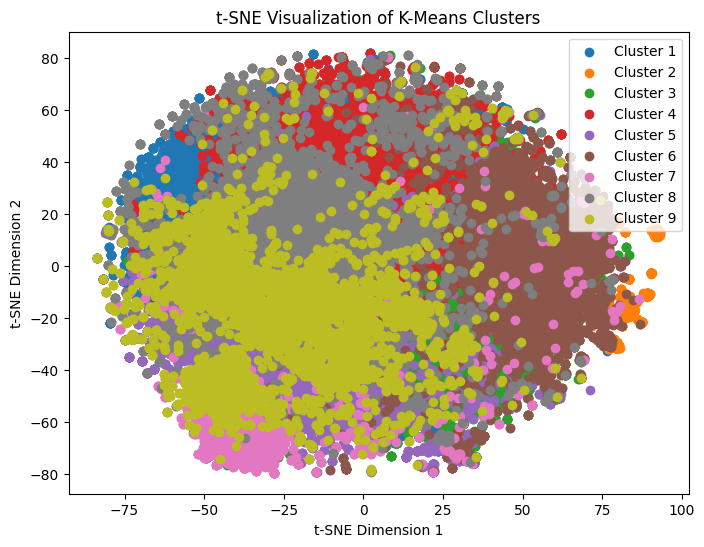

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Get cluster labels
cluster_labels = labels
k = 9
# Apply t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
word_embeddings_tsne = tsne.fit_transform(train_embeddings)

# Plot t-SNE visualization with cluster labels
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(word_embeddings_tsne[cluster_labels == i, 0], 
                word_embeddings_tsne[cluster_labels == i, 1], 
                label=f'Cluster {i+1}')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of K-Means Clusters')
plt.legend()
plt.show()

In [ ]:
song = """
It might seem crazy what I am 'bout to say
Sunshine, she's here, you can take a break
I'm a hot air balloon that could go to space
With the air, like I don't care, baby by the way
Huh (Because I'm happy)
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Here come bad news talking this and that (Yeah)
Well give me all you got, don't hold back (Yeah)
Well I should probably warn you I'll be just fine (Yeah)
No offense to you don't waste your time
Here's why
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Uh, bring me down
Can't nothing, bring me down
My level's too high to bring me down
Can't nothing, bring me down, I said
Bring me down, can't nothing
Bring me down
My level's too high to bring me down
Can't nothing, bring me down, I said
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Uh, bring me down (Happy, happy, happy, happy)
Can't nothing (Happy, happy, happy, happy)
Bring me down, my level's too high
To bring me down (Happy, happy, happy, happy)
Can't nothing (Happy, happy, happy, happy)
Bring me down, I said
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you (ayy, ayy, ayy)
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you (hey)
(Because I'm happy)
Clap along if you feel like that's what you wanna do
Come on
"""

In [ ]:
def predict(lyrics: str, labels: list[str]) -> str:
    song_vector = vectorise(lyrics)[None,:]
    return np.argsort(cosine_distance(X=song_vector ,centroids=centroids))

In [ ]:
predict(song,"")

array([[3, 0, 7, 5, 2, 8, 4, 6, 1]], dtype=int64)

In [ ]:
centroids

array([[ 0.05079666,  0.0180588 ,  0.02467367, ..., -0.06648331,
         0.00859566, -0.01146762],
       [ 0.00758812,  0.04291234,  0.05362005, ..., -0.06775615,
        -0.01270129,  0.07061082],
       [ 0.04581873,  0.03586245,  0.01468511, ..., -0.06360754,
         0.00997764, -0.00292837],
       ...,
       [ 0.06650604,  0.04006729,  0.03205198, ..., -0.08826765,
        -0.0026617 ,  0.02305975],
       [ 0.05019992,  0.04246702,  0.02013573, ..., -0.05161346,
         0.02821204, -0.02820733],
       [ 0.06642523,  0.05003025,  0.03072212, ..., -0.05602994,
         0.01728562, -0.00012713]])

In [ ]:
closest_indices_dict = {}
cluster_centers = centroids

# Find the indices of the closest embeddings to each centroid
for i, centroid in enumerate(cluster_centers):
    # Calculate distances between centroid and all embeddings
    distances = cosine_distance(train_embeddings, centroid[None, :])
    # Sort distances and get indices of the closest 5 embeddings
    closest_indices = np.argsort(distances.T)
    # Store indices in dictionary
    closest_indices_dict[f'Centroid {i}'] = closest_indices[0][0]


In [ ]:
closest_indices_dict

{'Centroid 0': 41931,
 'Centroid 1': 26223,
 'Centroid 2': 15229,
 'Centroid 3': 10521,
 'Centroid 4': 42933,
 'Centroid 5': 45718,
 'Centroid 6': 42698,
 'Centroid 7': 45646,
 'Centroid 8': 25769}

In [ ]:
print(benchmark_df.loc[closest_indices_dict["Centroid 8"]]["text"])

I once loved a girl, her skin it was bronze.  
With the innocence of a lamb, she was gentle like a fawn.  
I courted her proudly but now she is gone,  
Gone as the season she's taken.  
  
Through young summer's breeze, I stole her away  
From her mother and sister, though close did they stay.  
Each one of them suffering from the failures of their day,  
With strings of guilt they tried hard to guide us.  
  
Of the two sisters, I loved the young.  
With sensitive instincts, she was the creative one.  
The constant scapegoat, she was easily undone  
By the jealousy of others around her.  
  
For her parasite sister, I had no respect,  
Bound by her boredom, her pride to protect.  
Countless visions of the other she'd reflect  
As a crutch for her scenes and her society.  
  
Myself, for what I did, I cannot be excused,  
The changes I was going through can't even be used,  
For the lies that I told her in hopes not to lose  
The could-be dream-lover of my lifetime.  
  
With unknown c

In [ ]:
['Anticipation' 'Sadness' 'Fear']
{
    0:"Anticipation",
    1:"Sadness",
    2:


}

In [ ]:
for s in benchmark_df.loc[closest_indices_dict["Centroid 2"]]["text"][:10]:
    print(s)
    print("****************************")

There was a boy who came into this world  
At the hands of a holy woman in a holy place  
He wore a red coat and walked a bulldog  
Saw them reflected in the mirror of the lakes  
Lived in the shadow of the mountains  
With the smells of disinfectant, dusty old leather  
And the polished wood of his bed  
No more than a baby feeding swans on the river  
Holding the hands of his mother  
And the wax paper bag of yesterday's bread  
  
And his father on the other side of the world  
On the ships railings and some far away tide  
With the silent dry tear of home thoughts from abroad  
In his far away eyes  
In his far away eyes  
  
The smell of the wax on the wooden floor  
Mixture of polish and soap  
No children to fear or to play with  
Rows of empty hooks for the coats  
An upright piano and the boys in the choir  
Still remind him of just before he was born  
Remind him of just before he was breathing  
Strange misty visions of God  
Turn the cities into families  
Into villages of 

In [ ]:
embeddings = np.load("../embeddings/emotions_embeddings_v1.npy")
labels = np.array(
            [
                "Calmness",
                "Sadness",
                "Power",
                "Tension",
                "Amazement",
                "Solemnity",
                "Tenderness",
                "Joyful activation",
                "Nostalgia",
            ])

In [ ]:
np.argsort(cosine_distance(centroids, embeddings))

array([[4, 5, 6, 0, 1, 8, 7, 2, 3],
       [7, 2, 3, 4, 5, 6, 0, 1, 8],
       [8, 0, 1, 4, 5, 6, 7, 2, 3],
       [0, 1, 8, 4, 5, 6, 2, 3, 7],
       [0, 1, 8, 4, 5, 6, 7, 2, 3],
       [7, 2, 3, 4, 5, 6, 8, 0, 1],
       [4, 5, 6, 0, 1, 8, 7, 2, 3],
       [0, 1, 8, 4, 5, 6, 2, 3, 7],
       [0, 1, 8, 4, 5, 6, 2, 3, 7]], dtype=int64)

In [ ]:
print(benchmark_df.loc[closest_indices_dict["Centroid 8"]]["text"])

In [ ]:
mapping = {}
for i, l in enumerate(labels[np.argsort(cosine_distance(centroids, embeddings), axis=1)[:, :4]]):
    mapping[i] = list(l)

In [319]:
mapping

{0: ['Amazement', 'Solemnity', 'Tenderness', 'Calmness'],
 1: ['Joyful activation', 'Power', 'Tension', 'Amazement'],
 2: ['Nostalgia', 'Calmness', 'Sadness', 'Amazement'],
 3: ['Calmness', 'Sadness', 'Nostalgia', 'Amazement'],
 4: ['Calmness', 'Sadness', 'Nostalgia', 'Amazement'],
 5: ['Joyful activation', 'Power', 'Tension', 'Amazement'],
 6: ['Amazement', 'Solemnity', 'Tenderness', 'Calmness'],
 7: ['Calmness', 'Sadness', 'Nostalgia', 'Amazement'],
 8: ['Calmness', 'Sadness', 'Nostalgia', 'Amazement']}

In [266]:
benchmark_df.loc[closest_indices_dict["Centroid 0"]]

,artist,song,link,text
41931,LL Cool J,I Need Love,/l/ll+cool+j/i+need+love_20081043.html,When I'm alone in my room \r\nSometimes I sta...
26960,Cat Stevens,Foreigner Suite,/c/cat+stevens/foreigner+suite_20028113.html,"There are no words, I can use \r\nBecause the..."
54880,Vanilla Ice,I Love You,/v/vanilla+ice/i+love+you_20143680.html,"[Verse 1] \r\nGirl, I keep thinkin' of how I ..."
13192,Modern Talking,No. 1 Hit Medley,/m/modern+talking/no+1+hit+medley_20666841.html,Deep in my heart - there's a fire - a burning ...
9393,John Denver,Is It Love,/j/john+denver/is+it+love_20073885.html,I know how it feels to be head over heels \r\...


In [267]:
benchmark_df.loc[closest_indices_dict["Centroid 1"]]

,artist,song,link,text
26223,Boney M.,Kalimba De Luna,/b/boney+m/kalimba+de+luna_20022442.html,In the land of the sunshine \r\nPeople know h...
20365,Utada Hikaru,Final Distance,/u/utada+hikaru/final+distance_10162343.html,Ki ni naru noni kikenai \r\nOyogitsukarete ki...
45542,Nick Cave,Foi Na Cruz,/n/nick+cave/foi+na+cruz_20100200.html,"Foi na cruz, foi na cruz \r\nQue um dia \r\n..."
20374,Utada Hikaru,This Is Love,/u/utada+hikaru/this+is+love_20547234.html,"Yokisenu ai ni jiyuu ubawaretai ne \r\nOh, hi..."
48202,Pharrell Williams,Where's Yours At?,/p/pharrell+williams/wheres+yours+at_20676412....,(feat. Rohff) \r\n \r\n[Chorus - Pharrell] ...


In [268]:
benchmark_df.loc[closest_indices_dict["Centroid 2"]]

,artist,song,link,text
15229,Outkast,Decatur Psalm,/o/outkast/decatur+psalm_20103840.html,"[Cool Breeze] \r\nI call the crib they say ""B..."
8869,J Cole,In the Morning,/j/j+cole/in+the+morning_20899428.html,"Baby you summertime fine, I let you get on top..."
8886,J Cole,You Got It,/j/j+cole/you+got+it_20969036.html,"[Refrain: \r\nHey one time, hey one time \r\..."
8848,J Cole,Back To The Topic,/j/j+cole/back+to+the+topic_20894721.html,"Yea, n-gga \r\nI'm gon ahead and murder this ..."
41891,LL Cool J,1 In The Morning,/l/ll+cool+j/1+in+the+morning_10167076.html,"It's one in the mornin', \r\nYou know what ti..."


In [269]:
benchmark_df.loc[closest_indices_dict["Centroid 3"]]

,artist,song,link,text
10521,Kid Rock,My Oedipus Complex,/k/kid+rock/my+oedipus+complex_20078203.html,I need somebody won't you help me \r\nI need ...
51834,Snoop Dogg,I Believe In You,/s/snoop+dogg/i+believe+in+you_20127137.html,[Latoiya Williams] \r\nI'm so glad that you b...
34941,Guns N' Roses,Locomotive,/g/guns+n+roses/locomotive_10139577.html,Gonna find a way to cure this loneliness \r\n...
49196,Puff Daddy,After Love,/p/puff+daddy/after+love_20559614.html,(feat. Keri Hilson) \r\n \r\n[Keri:] \r\nI ...
34925,Guns N' Roses,Coma,/g/guns+n+roses/coma_10139584.html,See you've caught me in a coma \r\nAnd I don'...


In [270]:
benchmark_df.loc[closest_indices_dict["Centroid 4"]]

,artist,song,link,text
42933,Marillion,This Strange Engine,/m/marillion/this+strange+engine_20088964.html,There was a boy who came into this world \r\n...
40188,The Killers,A Dustland Fairytale,/k/killers/a+dustland+fairytale_20768319.html,Dustland fairytale beginning \r\nJust another...
38636,Joni Mitchell,Song For Sharon,/j/joni+mitchell/song+for+sharon_20075348.html,I went to Staten Island. \r\nTo buy myself a ...
31437,Emmylou Harris,Ballard Of A Runaway Horse,/e/emmylou+harris/ballard+of+a+runaway+horse_2...,(Leonard Cohen) \r\n \r\nSay a prayer for th...
25806,Bob Dylan,Dreamin' Of You,/b/bob+dylan/dreamin+of+you_20750947.html,The light \r\nIn this place \r\nIs really ba...


In [271]:
benchmark_df.loc[closest_indices_dict["Centroid 5"]]

,artist,song,link,text
45718,Nicki Minaj,Barbie World Intro,/n/nicki+minaj/barbie+world+intro_20873938.html,[Chorus:] \r\nI wanna get to know you \r\nI ...
41984,LL Cool J,We're Gonna Make It,/l/ll+cool+j/were+gonna+make+it_20686449.html,"I know the Lord, will make a way \r\nHe will ..."
57275,Ying Yang Twins,Take It Slow,/y/ying+yang+twins/take+it+slow_20538336.html,feat. Los Vegaz) \r\n \r\n[Chorus:] \r\n(Oo...
32267,Fabolous,It's Alright,/f/fabolous/its+alright_10112255.html,[Sean Paul] \r\nAll you need to know is the v...
49216,Puff Daddy,No Way Out,/p/puff+daddy/no+way+out_20112074.html,[Chorus:] \r\n[Kelly] \r\nThere's no way no ...


In [272]:
benchmark_df.loc[closest_indices_dict["Centroid 6"]]

,artist,song,link,text
42698,Mariah Carey,O Little Town Of Bethlehem,/m/mariah+carey/o+little+town+of+bethlehem_208...,"Oh, little town of Bethlehem \r\nHow still we..."
1467,Bing Crosby,Oh Little Town Of Bethlehem,/b/bing+crosby/oh+little+town+of+bethlehem_207...,"Oh, little town of Bethlehem \r\nHow still we..."
13447,Nat King Cole,Oh Little Town Of Bethlehem,/n/nat+king+cole/oh+little+town+of+bethlehem_2...,"Oh, little town of Bethlehem \r\nHow still we..."
34236,Gloria Gaynor,O Holy Night,/g/gloria+gaynor/o+holy+night_21073158.html,Oh holy night! \r\nThe stars are brightly shi...
26909,Carpenters,O Holy Night,/c/carpenters/o+holy+night_20516511.html,O holy night! The stars are brightly shining ...


In [273]:
benchmark_df.loc[closest_indices_dict["Centroid 7"]]

,artist,song,link,text
45646,Nick Drake,Rena,/n/nick+drake/rena_20483102.html,I got my plans \r\nFrom trembling hands \r\n...
34925,Guns N' Roses,Coma,/g/guns+n+roses/coma_10139584.html,See you've caught me in a coma \r\nAnd I don'...
54243,Ufo,Flying,/u/ufo/flying_20141854.html,[disputed lyrics in brackets] \r\nHave you ev...
4572,Dream Theater,Space-Dye Vest,/d/dream+theater/space+dye+vest_20043326.html,Falling through pages of Martens on angels \r...
43132,Maroon 5,Losing My Mind,/m/maroon+5/losing+my+mind_20600408.html,It's so hard to find you \r\nI'm standing rig...


In [177]:
np.save("kmeans_centeroids_v1.npy", centroids)

In [178]:
centeroids.shape

(7, 300)

In [217]:
d = {}
for i, l in enumerate(labels[np.argsort(cosine_distance(centroids, embeddings), axis=1)[:, :3]]):
    d[i] = list(l)

In [218]:
d

{0: ['Calmness', 'Sadness', 'Nostalgia'],
 1: ['Joyful activation', 'Power', 'Tension'],
 2: ['Amazement', 'Solemnity', 'Tenderness'],
 3: ['Joyful activation', 'Power', 'Tension'],
 4: ['Nostalgia', 'Calmness', 'Sadness'],
 5: ['Amazement', 'Solemnity', 'Tenderness'],
 6: ['Calmness', 'Sadness', 'Amazement'],
 7: ['Calmness', 'Sadness', 'Nostalgia'],
 8: ['Calmness', 'Sadness', 'Nostalgia']}

In [219]:
dis = cosine_distance(centroids, embeddings)

In [221]:
np.argsort(cosine_distance(centroids, embeddings))

array([[0, 1, 8, 4, 5, 6, 2, 3, 7],
       [7, 2, 3, 4, 5, 6, 8, 0, 1],
       [4, 5, 6, 0, 1, 8, 7, 2, 3],
       [7, 2, 3, 4, 5, 6, 0, 1, 8],
       [8, 0, 1, 4, 5, 6, 7, 2, 3],
       [4, 5, 6, 8, 0, 1, 7, 2, 3],
       [0, 1, 4, 5, 6, 8, 2, 3, 7],
       [0, 1, 8, 4, 5, 6, 7, 2, 3],
       [0, 1, 8, 4, 5, 6, 2, 3, 7]], dtype=int64)

In [199]:
d

{0: ['Calmness', 'Sadness'],
 1: ['Joyful activation', 'Power'],
 2: ['Amazement', 'Solemnity'],
 3: ['Joyful activation', 'Power'],
 4: ['Nostalgia', 'Calmness'],
 5: ['Amazement', 'Solemnity'],
 6: ['Calmness', 'Sadness'],
 7: ['Calmness', 'Sadness'],
 8: ['Calmness', 'Sadness']}

In [193]:
cosine_distance(centroids, embeddings)[:, :2]

array([[0.03059446, 0.03059446],
       [0.03834659, 0.03834659],
       [0.03909744, 0.03909744],
       [0.37645089, 0.37645089],
       [0.0127083 , 0.0127083 ],
       [0.00829108, 0.00829108],
       [0.06959563, 0.06959563],
       [0.05214194, 0.05214194],
       [0.03519053, 0.03519053]])

In [ ]:
{0: ['Calmness', 'Sadness'], 1:['Joyful activation', 'Power'], 2:labels[4], 3:labels[]}

In [189]:
raw_df.loc[np.argmin(cosine_distance(centroids, scaled_lyrics_embeddings), axis=1)]

,artist,song,link,text
54243,Ufo,Flying,/u/ufo/flying_20141854.html,[disputed lyrics in brackets] \r\nHave you ev...
45718,Nicki Minaj,Barbie World Intro,/n/nicki+minaj/barbie+world+intro_20873938.html,[Chorus:] \r\nI wanna get to know you \r\nI ...
41931,LL Cool J,I Need Love,/l/ll+cool+j/i+need+love_20081043.html,When I'm alone in my room \r\nSometimes I sta...
20365,Utada Hikaru,Final Distance,/u/utada+hikaru/final+distance_10162343.html,Ki ni naru noni kikenai \r\nOyogitsukarete ki...
5072,Eminem,Crack A Bottle,/e/eminem/crack+a+bottle_20775965.html,Ladies and gentlemen \r\nThe moment you've al...
54879,Vanilla Ice,I Go Down,/v/vanilla+ice/i+go+down_20143665.html,[Verse 1] \r\nI Remember way back when \r\nL...
36722,Indiana Bible College,Because Of Love,/i/indiana+bible+college/because+of+love_20997...,[Verse:] \r\nBecause of love He left His thro...
42933,Marillion,This Strange Engine,/m/marillion/this+strange+engine_20088964.html,There was a boy who came into this world \r\n...
4572,Dream Theater,Space-Dye Vest,/d/dream+theater/space+dye+vest_20043326.html,Falling through pages of Martens on angels \r...
